## 데이터 불러오기 & 확인

In [2]:
import os 
import pandas as pd

In [3]:
os.chdir(r'C:\Users\User\LearningSpoons\파이썬 포트폴리오\프로젝트 2. 로스만 상점매출 예측\data')

In [174]:
test = pd.read_csv('lspoons_test.csv')
train = pd.read_csv('lspoons_train.csv')
store = pd.read_csv('store.csv')

In [175]:
train.head()

,id,Store,Date,Sales,Promo,StateHoliday,SchoolHoliday
0,14929,85,2015-05-01,11360,1,a,0
1,14930,512,2015-05-01,10534,1,a,0
2,14931,1097,2015-05-01,17039,1,a,0
3,14932,1,2015-04-30,6228,1,0,0
4,14933,9,2015-04-30,9717,1,0,0


#### 컬럼의 의미  

1. id : 아이디
2. Store : 각 상점의 id
3. Date : 기준날짜
4. Sales : 판매 수
5. Promo : 프로모션 진행여부 (진행-1, 진행x-0)
6.StateHoliday : 주(state)의 휴일 (0,a,b,c)
7.SchoolHoliday : 학교 휴일 (휴일-1, 휴일x-0)

In [176]:
train['StateHoliday'].value_counts()

0    62208
a       18
b       13
c        5
Name: StateHoliday, dtype: int64

# 1. StateHoliday 변수 변환

In [177]:
train = pd.get_dummies(columns=['StateHoliday'], data = train)
test = pd.get_dummies(columns=['StateHoliday'], data = test)

In [178]:
train.head()

,id,Store,Date,Sales,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,14929,85,2015-05-01,11360,1,0,0,1,0,0
1,14930,512,2015-05-01,10534,1,0,0,1,0,0
2,14931,1097,2015-05-01,17039,1,0,0,1,0,0
3,14932,1,2015-04-30,6228,1,0,1,0,0,0
4,14933,9,2015-04-30,9717,1,0,1,0,0,0


In [179]:
test.head()

,id,Store,Date,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a
0,0,1,2015-07-01,1,0,1,0
1,1,9,2015-07-01,1,1,1,0
2,2,11,2015-07-01,1,0,1,0
3,3,12,2015-07-01,1,0,1,0
4,4,14,2015-07-01,1,1,1,0


train과 test에 있는 컬럼이 달라서 통일시켜 주어야함!!

In [180]:
# 존재하지 않기 때문에 0으로 채워넣기
test['StateHoliday_b'] = 0
test['StateHoliday_c'] = 0

# 2. Date 변수를 활용한 FE

In [181]:
train['Date'] = pd.to_datetime(train['Date'])   # datetime 형식으로 만들기 dtype('<M8[ns]')
test['Date'] = pd.to_datetime(test['Date'])

In [182]:
# train['Date'].dt.year  # 년
# train['Date'].dt.month  # 월
# train['Date'].dt.weekday  # 요일

In [183]:
# 날짜 컬럼 생성
train['weekday'] = train['Date'].dt.weekday
test['weekday'] = test['Date'].dt.weekday

train['year'] = train['Date'].dt.year
test['year'] = test['Date'].dt.year

train['month'] = train['Date'].dt.month
test['month'] = test['Date'].dt.month

In [184]:
train.columns

Index(['id', 'Store', 'Date', 'Sales', 'Promo', 'SchoolHoliday',
       'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
       'weekday', 'year', 'month'],
      dtype='object')

# 3. 베이스라인 모델링

In [185]:
!pip install xgboost

In [186]:
from xgboost import XGBRegressor

In [187]:
# 모델생성
xgb = XGBRegressor( n_estimators =300, learning_rate = 0.1, random_state = 2020 )

In [188]:
# 모델학습
xgb.fit(train[['Promo', 'SchoolHoliday',
       'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
       'weekday', 'year', 'month']], 
        train['Sales'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=2020,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [189]:
# 예측
test['Sales'] = xgb.predict(test[['Promo', 'SchoolHoliday',
       'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
       'weekday', 'year', 'month']])

In [190]:
test[['id', 'Sales']].to_csv("submission.csv", index = False )

# 4. 변수선택 

아무 연관 없는 변수를 포함시킨다면 성능이 떨어질 수 있음!    

성능 올리기 위해서는 중요한 변수만 포함시키기

In [191]:
# 변수 중요도 체크
xgb.feature_importances_

array([7.0119339e-01, 5.6813192e-02, 8.5970545e-03, 3.9727646e-03,
       1.7045789e-03, 8.6085265e-06, 8.5364282e-02, 5.7804178e-02,
       8.4541924e-02], dtype=float32)

In [192]:
# 순서대로 변수 중요도가 나오게됨
input_var = ['Promo', 'SchoolHoliday',
       'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
       'weekday', 'year', 'month']

In [193]:
imp_df = pd.DataFrame({'var' : input_var,
                      "imp" : xgb.feature_importances_})

In [194]:
imp_df = imp_df.sort_values(['imp'], ascending=False)

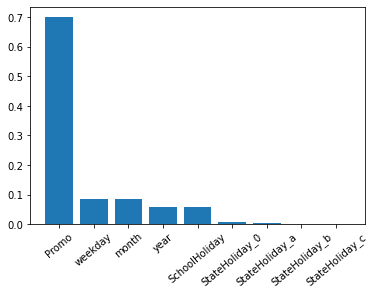

In [197]:
import matplotlib.pyplot as plt
plt.bar(imp_df['var'],imp_df['imp'])
plt.xticks(rotation=40)
plt.show()

SchoolHoliday변수까지만 유의미한 것으로 보임

In [51]:
# cross validation - 교차검증
from sklearn.model_selection import cross_val_score

In [52]:
# 교차검증 (모델, input, target, 평가점수, 몇번할지)  (모든변수 사용 시)
cross_val_score(xgb, train[input_var], train['Sales'], 
                scoring = "neg_mean_squared_error", cv=3)

# "neg_mean_squared_error" - 음의 mse

array([ -7442398.68110158, -10165475.69817356,  -7896996.52747543])

In [54]:
# 교차검증 (모델, input, target, 평가점수, 몇번할지)  (변수조정 시)
cross_val_score(xgb, train[['Promo', 'SchoolHoliday','weekday', 'year', 'month']], 
                train['Sales'], scoring = "neg_mean_squared_error", cv=3)

array([ -7437045.50574847, -10109891.53781048,  -7579785.74399885])

변수 조정 하니 mse가 줄어듦 = 예측성능이 좋아짐

**그럼 상위 몇개의 변수를 활용해야 할까???**

In [55]:
import numpy as np

In [56]:
score_list = []
selected_varnum = []

for i in range(1,10):
    selected_var = imp_df['var'].iloc[:i].to_list()
    scores = cross_val_score(xgb, 
                             train[selected_var], 
                             train['Sales'], 
                             scoring = "neg_mean_squared_error", cv=3)
    score_list.append(-np.mean(scores))  # mse 양수화
    selected_varnum.append(i)
    print(i)

1
2
3
4
5
6
7
8
9


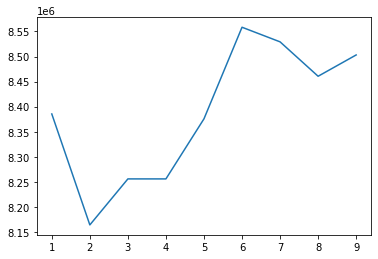

In [59]:
plt.plot(selected_varnum, score_list)

### 상위 2개 변수만 활용했을때 mse가 가장 낮음!!! 2개만 활용하는게 적절함

In [61]:
# 확인해보자
cross_val_score(xgb, train[['Promo', 'weekday']], 
                train['Sales'], scoring = "neg_mean_squared_error", cv=3)

array([ -7241548.38898523, -10134534.97381444,  -7116067.92521244])

그럼 이걸 적용해서 다시 학습시킨 후에 다시 제출해보기

In [62]:
# 모델학습
xgb.fit(train[['Promo', 'weekday']], 
        train['Sales'])

# 예측
test['Sales'] = xgb.predict(test[['Promo', 'weekday']])

# 저장
test[['id', 'Sales']].to_csv("submission2.csv", index = False )

# 5. 보조데이터 활용  (store data)

In [63]:
store

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


**컬럼 정보**

1. store : 상점번호
2. storetype : 상점 타입
3. Assortment : 다른 상점 타입
4. CompetitionDistance : 경쟁상점과의 거리
5. CompetitionOpenSinceMonth : 경쟁상점이 언제오픈했는지(월)
6. CompetitionOpenSinceYear : 경쟁상점이 언제오픈했는지(년)
7. Promo2 : 지속적인 프로모션 (유-1, 무-0)
8. Promo2SinceWeek : 프로모션 시작한 주
9. Promo2SinceYear : 프로모션 시작한 년
10. PromoInterval : 프로모션 주기

In [98]:
train.loc[train['Store'] ==1]  # train 은 시기마다 나와있음

,id,Store,Date,Sales,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,weekday,year,month
3,14932,1,2015-04-30,6228,1,0,1,0,0,0,3,2015,4
303,15232,1,2015-04-29,5775,1,0,1,0,0,0,2,2015,4
603,15532,1,2015-04-28,5199,1,0,1,0,0,0,1,2015,4
903,15832,1,2015-04-27,5575,1,0,1,0,0,0,0,2015,4
1213,16142,1,2015-04-25,4318,0,0,1,0,0,0,5,2015,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,75904,1,2014-08-06,5337,1,1,1,0,0,0,2,2014,8
61227,76156,1,2014-08-05,5433,1,1,1,0,0,0,1,2014,8
61479,76408,1,2014-08-04,5655,1,1,1,0,0,0,0,2014,8
61740,76669,1,2014-08-02,4731,0,1,1,0,0,0,5,2014,8


In [67]:
store.loc[store['Store'] ==1]   # store는 어떤 한 시점만 나와있음

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


train 과 store 를 합치고 싶을때?  merge 활용

In [204]:
test

,id,Store,Date,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,weekday,year,month,Sales
0,0,1,2015-07-01,1,0,1,0,0,0,2,2015,7,9451.890625
1,1,9,2015-07-01,1,1,1,0,0,0,2,2015,7,9701.730469
2,2,11,2015-07-01,1,0,1,0,0,0,2,2015,7,9451.890625
3,3,12,2015-07-01,1,0,1,0,0,0,2,2015,7,9451.890625
4,4,14,2015-07-01,1,1,1,0,0,0,2,2015,7,9701.730469
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14924,14924,1106,2015-05-02,0,0,1,0,0,0,5,2015,5,6551.878418
14925,14925,1108,2015-05-02,0,0,1,0,0,0,5,2015,5,6551.878418
14926,14926,1111,2015-05-02,0,0,1,0,0,0,5,2015,5,6551.878418
14927,14927,1112,2015-05-02,0,0,1,0,0,0,5,2015,5,6551.878418


In [207]:
train_m = pd.merge(train, store, on=['Store'], how='left')
test_m = pd.merge(test, store, on=['Store'], how='left')

In [208]:
test_m

,id,Store,Date,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,weekday,...,Sales,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,0,1,2015-07-01,1,0,1,0,0,0,2,...,9451.890625,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,9,2015-07-01,1,1,1,0,0,0,2,...,9701.730469,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
2,2,11,2015-07-01,1,0,1,0,0,0,2,...,9451.890625,a,c,960.0,11.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
3,3,12,2015-07-01,1,0,1,0,0,0,2,...,9451.890625,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
4,4,14,2015-07-01,1,1,1,0,0,0,2,...,9701.730469,a,a,1300.0,3.0,2014.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14924,14924,1106,2015-05-02,0,0,1,0,0,0,5,...,6551.878418,a,c,5330.0,9.0,2011.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
14925,14925,1108,2015-05-02,0,0,1,0,0,0,5,...,6551.878418,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
14926,14926,1111,2015-05-02,0,0,1,0,0,0,5,...,6551.878418,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
14927,14927,1112,2015-05-02,0,0,1,0,0,0,5,...,6551.878418,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN


In [209]:
# 현재시점으로부터 몇개월전 오픈했는가?

train_m['CompetitionOpen'] = 12*(train_m['year'] - train_m['CompetitionOpenSinceYear']) + \
                            (train_m['month'] - train_m['CompetitionOpenSinceMonth'])

test_m['CompetitionOpen'] = 12*(test_m['year'] - test_m['CompetitionOpenSinceYear']) + \
                            (test_m['month'] - test_m['CompetitionOpenSinceMonth'])

In [210]:
# 현재시점까지 몇개월 프로모션 했는가?

train_m['WeekOfYear'] = train_m['Date'].dt.weekofyear
test_m['WeekOfYear'] = test_m['Date'].dt.weekofyear

C:\Users\User\AppData\Local\Temp/ipykernel_10244/2265362059.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_m['WeekOfYear'] = train_m['Date'].dt.weekofyear
C:\Users\User\AppData\Local\Temp/ipykernel_10244/2265362059.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test_m['WeekOfYear'] = test_m['Date'].dt.weekofyear


In [211]:
train_m['PromoOpen'] = 12*(train_m['year'] - train_m['Promo2SinceYear']) + \
                        (train_m['WeekOfYear'] - train_m['Promo2SinceYear']) / 4

test_m['PromoOpen'] = 12*(test_m['year'] - test_m['Promo2SinceYear']) + \
                        (test_m['WeekOfYear'] - test_m['Promo2SinceYear']) / 4

In [212]:
train_m.dtypes   # object type -> one-hot encoding

id                                    int64
Store                                 int64
Date                         datetime64[ns]
Sales                                 int64
Promo                                 int64
SchoolHoliday                         int64
StateHoliday_0                        uint8
StateHoliday_a                        uint8
StateHoliday_b                        uint8
StateHoliday_c                        uint8
weekday                               int64
year                                  int64
month                                 int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
CompetitionOpen                 

In [213]:
train_m = pd.get_dummies(columns = ['StoreType'], data=train_m)
test_m = pd.get_dummies(columns = ['StoreType'], data=test_m)

train_m = pd.get_dummies(columns = ['Assortment'], data=train_m)
test_m = pd.get_dummies(columns = ['Assortment'], data=test_m)

train_m = pd.get_dummies(columns = ['PromoInterval'], data=train_m)
test_m = pd.get_dummies(columns = ['PromoInterval'], data=test_m)

# 6. 2차 모델링 (변수선택)

In [214]:
train_m.columns

Index(['id', 'Store', 'Date', 'Sales', 'Promo', 'SchoolHoliday',
       'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
       'weekday', 'year', 'month', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'CompetitionOpen', 'WeekOfYear',
       'PromoOpen', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_a', 'Assortment_b', 'Assortment_c',
       'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct',
       'PromoInterval_Mar,Jun,Sept,Dec'],
      dtype='object')

In [215]:
input_var = [ 'Promo', 'SchoolHoliday',
       'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
       'weekday', 'year', 'month', 'CompetitionDistance',
       'Promo2',
       'CompetitionOpen', 'WeekOfYear',
       'PromoOpen', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_a', 'Assortment_b', 'Assortment_c',
       'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct',
       'PromoInterval_Mar,Jun,Sept,Dec']

In [216]:
# 모델생성
xgb = XGBRegressor( n_estimators=300, learning_rate = 0.1, random_state=2020)

In [217]:
# 모델학습
xgb.fit(train_m[input_var], train_m['Sales'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=2020,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [218]:
# 변수중요도 체크
imp_df = pd.DataFrame({'var' : input_var,
                       'imp' : xgb.feature_importances_})

In [219]:
imp_df = imp_df.sort_values(['imp'], ascending=False)

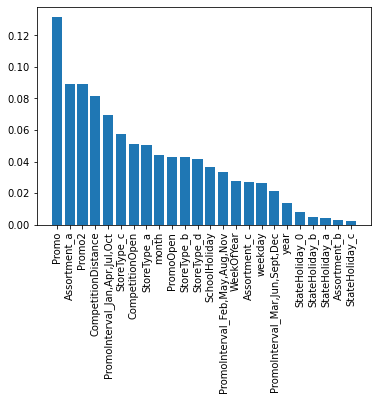

In [138]:
plt.bar(imp_df['var'], imp_df['imp'])
plt.xticks(rotation =90)
plt.show()

In [139]:
len(input_var)

24

In [143]:
score_list = []
selected_varnum = []

for i in range(1,25):
    selected_var = imp_df['var'].iloc[:i].to_list()
    scores = cross_val_score(xgb, 
                             train_m[selected_var], 
                             train_m['Sales'], 
                             scoring = "neg_mean_squared_error", cv=3)
    score_list.append(-np.mean(scores))  # mse 양수화
    selected_varnum.append(i)
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


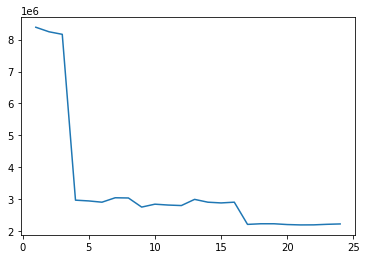

In [144]:
plt.plot(selected_varnum, score_list)

변수의 수가 17 정도에서 score가 거의 변동이 없음  -> 17선택


In [266]:
input_var = imp_df['var'].iloc[:2].tolist()

In [221]:
# 교차검증
cross_val_score(xgb, train_m[input_var], train_m['Sales'], scoring='neg_mean_squared_error', cv=3)

array([-1851049.62506742, -3120322.91076385, -1672187.01095951])

다시 적용해서 제출해보기

In [223]:
# 모델학습
xgb.fit(train_m[input_var], 
        train_m['Sales'])

# 예측
test_m['Sales'] = xgb.predict(test_m[input_var])

# 저장
test_m[['id', 'Sales']].to_csv("submission3.csv", index = False )

# 7. 파라미터 튜닝

In [232]:
## n_estimators 파라미터를 최적화
estim_list = [100,200,300,400,500,600,700,800,900]
score_list = []

In [233]:
for i in estim_list:
    xgb = XGBRegressor( n_estimators=i, learning_rate = 0.1, random_state = 2020)
    scores = cross_val_score(xgb, train_m[input_var], train_m['Sales'], scoring="neg_mean_squared_error",cv=3)
    score_list.append(-np.mean(scores))
    print(i)

100
200
300
400
500
600
700
800
900


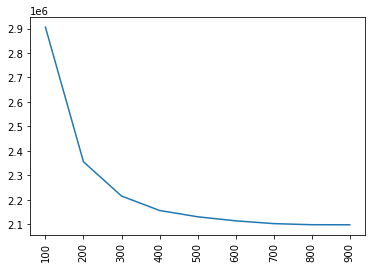

In [236]:
plt.plot(estim_list, score_list)
plt.xticks(rotation=90)
plt.show()

600이후는 변화가 잘 보이지 않음

In [275]:
# 모델생성
xgb = XGBRegressor( n_estimators=600, learning_rate = 0.1, random_state=2020)

# 모델학습
xgb.fit(train_m[input_var], train_m['Sales'])

# 예측
test_m['Sales'] = xgb.predict(test_m[input_var])

# 저장
test_m[['id', 'Sales']].to_csv("submission5.csv", index = False )

In [276]:
# 교차검증
cross_val_score(xgb, train_m[input_var], train_m['Sales'], scoring='neg_mean_squared_error', cv=3)

array([ -7251690.62335897, -10124846.531935  ,  -7353044.41098877])

변수2개, n_estimators=600 일때 rmse가 1554점으로 최소값나옴

# optuna  이용 하이퍼파라미터 조정 (시도중)

In [305]:
import optuna

#XGB 하이퍼 파라미터들 값 지정
def objectiveXGB(trial,X,y):

    X_train, X_test, y_train, y_test = train_test_split(train_m[input_var], test_m['Sales'], test_size=0.2, shuffle=False, random_state=42)

    #https://xgboost.readthedocs.io/en/latest/parameter.html 참고
    param = {
    'verbosity':1,
    'objective':'reg:squarederror', #'reg:linear' 회귀
    'max_depth':trial.suggest_int('max_depth',3,30),
    'learning_rate':trial.suggest_loguniform('learning_rate',1e-8,1e-2),
    'n_estimators':trial.suggest_int('n_estimators',100,3000),
    'subsample':trial.suggest_loguniform('subsample',0.7,1),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 300 ),
    'alpha': trial.suggest_loguniform( 'alpha', 1e-3, 10.0),
    'random_state': 42}

    #학습모델 생성
    model=XGBRegressor(**param)
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=25,verbose=False)

    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    return mae
# MAE가 최소가 되는 방향으로 학습을 진행
studyXGB=optuna.create_study(direction='minimize')

# n_trials 지정
studyXGB.optimize(lambda trial: objectiveXGB(trial, X, y), n_trials=100) 

print('study.best_params:', studyXGB.best_trial.value)
print('Number of finished trials:', len(studyXGB.trials))
print('Best trial:', studyXGB.best_trial.params)
print('study.best_params:', studyXGB.best_params)
#파라미터 중요도 시각화
optuna.visualization.plot_param_importances(studyXGB)

[I 2022-04-22 11:17:20,744] A new study created in memory with name: no-name-c123ed44-23af-4c7e-9153-4805a67d701d
[W 2022-04-22 11:17:20,747] Trial 0 failed because of the following error: NameError("name 'X' is not defined")
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\User\AppData\Local\Temp/ipykernel_10244/1859318819.py", line 31, in <lambda>
    studyXGB.optimize(lambda trial: objectiveXGB(trial, X, y), n_trials=100)
NameError: name 'X' is not defined


NameError: name 'X' is not defined